# Machine Learning Workflow on Diabetes Data

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Phase 0 -  Data Preparation

For this tutorial I will use the “Pima Indians Diabetes Database” provided by the UCI Machine Learning Repository (famous repository for machine learning data sets).

URL : [https://archive.ics.uci.edu/ml/datasets/pima+indians+diabetes]

## Phase 1 -  Data Exploration

In [2]:
diabetes = pd.read_csv('datasets/diabetes.csv')
print(diabetes.columns)

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')


In [3]:
diabetes.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [4]:
print("Diabetes data set dimensions : {}".format(diabetes.shape))

Diabetes data set dimensions : (768, 9)


In [5]:
diabetes.groupby('Outcome').size()

Outcome
0    500
1    268
dtype: int64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000005BF416B240>,
      dtype=object)

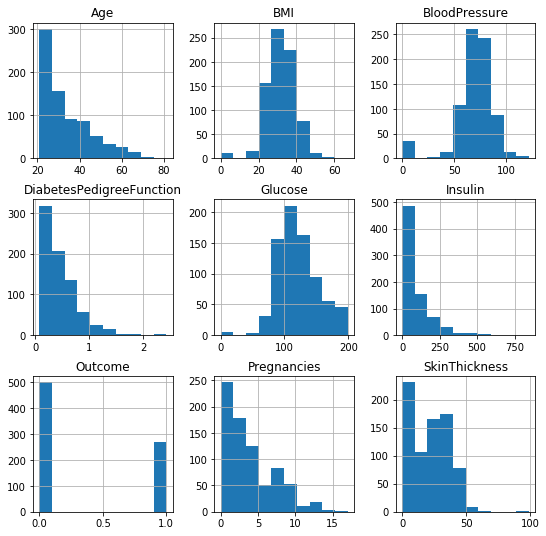

In [6]:
diabetes.hist(figsize=(9, 9))

Outcome
0    [[AxesSubplot(0.125,0.670278;0.215278x0.209722...
1    [[AxesSubplot(0.125,0.670278;0.215278x0.209722...
dtype: object

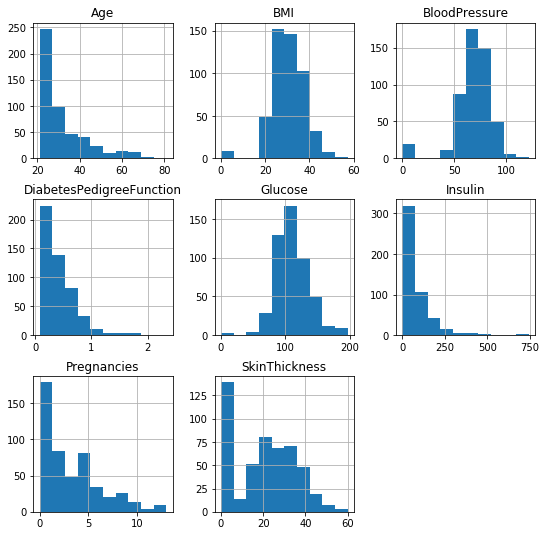

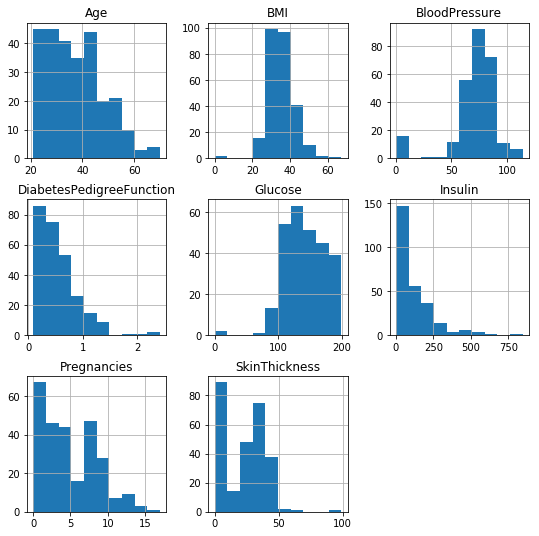

In [7]:
diabetes.groupby('Outcome').hist(figsize=(9, 9))

## Phase 2 - Data Cleaning

### Missing or Null Data points

In [8]:
diabetes.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [9]:
diabetes.isna().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

### Unexpected Outliers

In [10]:
print("Total : ", diabetes[diabetes.BloodPressure == 0].shape[0])
print(diabetes[diabetes.BloodPressure == 0].groupby('Outcome')['Age'].count())

Total :  35
Outcome
0    19
1    16
Name: Age, dtype: int64


In [11]:
print("Total : ", diabetes[diabetes.Glucose == 0].shape[0])
print(diabetes[diabetes.Glucose == 0].groupby('Outcome')['Age'].count())

Total :  5
Outcome
0    3
1    2
Name: Age, dtype: int64


In [12]:
print("Total : ", diabetes[diabetes.SkinThickness == 0].shape[0])
print(diabetes[diabetes.SkinThickness == 0].groupby('Outcome')['Age'].count())

Total :  227
Outcome
0    139
1     88
Name: Age, dtype: int64


In [13]:
print("Total : ", diabetes[diabetes.BMI == 0].shape[0])
print(diabetes[diabetes.BMI == 0].groupby('Outcome')['Age'].count())

Total :  11
Outcome
0    9
1    2
Name: Age, dtype: int64


In [14]:
print("Total : ", diabetes[diabetes.Insulin == 0].shape[0])
print(diabetes[diabetes.Insulin == 0].groupby('Outcome')['Age'].count())

Total :  374
Outcome
0    236
1    138
Name: Age, dtype: int64


In [15]:
diabetes_mod = diabetes[(diabetes.BloodPressure != 0) & (diabetes.BMI != 0) & (diabetes.Glucose != 0)]
print(diabetes_mod.shape)

(724, 9)


## Phase 3 - Model Selection

In [16]:
# Features/Response
feature_names = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']
X = diabetes_mod[feature_names]
y = diabetes_mod.Outcome

## Phase 4 - Model Selection

In [17]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

In [18]:
# Initial model selection process
models = []

models.append(('KNN', KNeighborsClassifier()))
models.append(('SVC', SVC(gamma='scale')))
models.append(('LR', LogisticRegression(solver='lbfgs', max_iter=4000)))
models.append(('DT', DecisionTreeClassifier()))
models.append(('GNB', GaussianNB()))
models.append(('RF', RandomForestClassifier(n_estimators=100)))
models.append(('GB', GradientBoostingClassifier()))

### Using Train/Test split

In [19]:
# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = diabetes_mod.Outcome, random_state=0)

In [20]:
names = []
scores = []

for name, model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    scores.append(accuracy_score(y_test, y_pred))
    names.append(name)

tr_split = pd.DataFrame({'Name': names, 'Score': scores})
print(tr_split)

  Name     Score
0  KNN  0.729282
1  SVC  0.740331
2   LR  0.779006
3   DT  0.740331
4  GNB  0.734807
5   RF  0.784530
6   GB  0.773481


### Using K-Fold cross validation

In [21]:
strat_k_fold = StratifiedKFold(n_splits=10, random_state=10)

names = []
scores = []

for name, model in models:
    
    score = cross_val_score(model, X, y, cv=strat_k_fold, scoring='accuracy').mean()
    names.append(name)
    scores.append(score)

kf_cross_val = pd.DataFrame({'Name': names, 'Score': scores})
print(kf_cross_val)

  Name     Score
0  KNN  0.711521
1  SVC  0.728074
2   LR  0.773662
3   DT  0.677256
4  GNB  0.755681
5   RF  0.776457
6   GB  0.764091


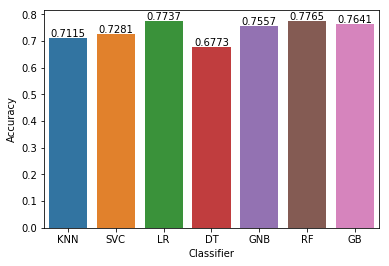

In [22]:
axis = sns.barplot(x = 'Name', y = 'Score', data = kf_cross_val)
axis.set(xlabel='Classifier', ylabel='Accuracy')

for p in axis.patches:
    height = p.get_height()
    axis.text(p.get_x() + p.get_width()/2, height + 0.005, '{:1.4f}'.format(height), ha="center") 
    
plt.show()

## Phase 5 - Feature Selection (Revisited)

In [23]:
from sklearn.feature_selection import RFECV

### Logistic Regression

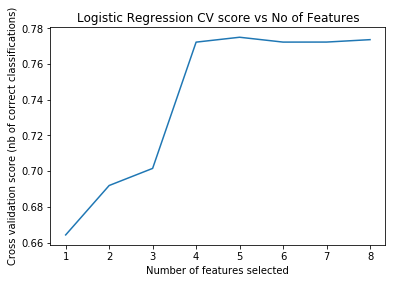

In [24]:
logreg_model = LogisticRegression(solver='lbfgs', max_iter=4000)

rfecv = RFECV(estimator=logreg_model, step=1, cv=strat_k_fold, scoring='accuracy')
rfecv.fit(X, y)

plt.figure()
plt.title('Logistic Regression CV score vs No of Features')
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [25]:
feature_importance = list(zip(feature_names, rfecv.support_))

new_features = []

for key,value in enumerate(feature_importance):
    if(value[1]) == True:
        new_features.append(value[0])
        
print(new_features)

['Pregnancies', 'Glucose', 'BMI', 'DiabetesPedigreeFunction', 'Age']


In [26]:
# Calculate accuracy scores 
X_new = diabetes_mod[new_features]

initial_score = cross_val_score(logreg_model, X, y, cv=strat_k_fold, scoring='accuracy').mean()
print("Initial accuracy : {} ".format(initial_score))

fe_score = cross_val_score(logreg_model, X_new, y, cv=strat_k_fold, scoring='accuracy').mean()
print("Accuracy after Feature Selection : {} ".format(fe_score))

Initial accuracy : 0.7736617574549275 
Accuracy after Feature Selection : 0.7750125945934357 


### Gradient Boost

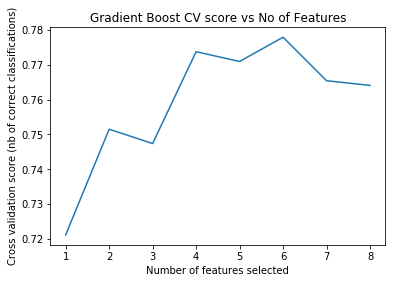

In [27]:
gb_model = GradientBoostingClassifier()

gb_rfecv = RFECV(estimator=gb_model, step=1, cv=strat_k_fold, scoring='accuracy')
gb_rfecv.fit(X, y)

plt.figure()
plt.title('Gradient Boost CV score vs No of Features')
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(gb_rfecv.grid_scores_) + 1), gb_rfecv.grid_scores_)
plt.show()

In [28]:
feature_importance = list(zip(feature_names, gb_rfecv.support_))

new_features = []

for key,value in enumerate(feature_importance):
    if(value[1]) == True:
        new_features.append(value[0])
        
print(new_features)

['Pregnancies', 'Glucose', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']


In [29]:
X_new_gb = diabetes_mod[new_features]

initial_score = cross_val_score(gb_model, X, y, cv=strat_k_fold, scoring='accuracy').mean()
print("Initial accuracy : {} ".format(initial_score))

fe_score = cross_val_score(gb_model, X_new_gb, y, cv=strat_k_fold, scoring='accuracy').mean()
print("Accuracy after Feature Selection : {} ".format(fe_score))

Initial accuracy : 0.7654420434325895 
Accuracy after Feature Selection : 0.7833459279267692 


## Phase 6 - Model Parameter Tuning

In [30]:
from sklearn.model_selection import GridSearchCV

In [31]:
# Specify parameters
c_values = list(np.arange(1, 10))

param_grid = [
    {'C': c_values, 'penalty': ['l1'], 'solver' : ['liblinear'], 'multi_class' : ['ovr']},
    {'C': c_values, 'penalty': ['l2'], 'solver' : ['liblinear', 'newton-cg', 'lbfgs'], 'multi_class' : ['ovr']}
]

In [36]:
grid = GridSearchCV(LogisticRegression(), param_grid, cv=strat_k_fold, scoring='accuracy')
grid.fit(X_new, y)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=10, shuffle=False),
       error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'C': [1, 2, 3, 4, 5, 6, 7, 8, 9], 'penalty': ['l1'], 'solver': ['liblinear'], 'multi_class': ['ovr']}, {'C': [1, 2, 3, 4, 5, 6, 7, 8, 9], 'penalty': ['l2'], 'solver': ['liblinear', 'newton-cg', 'lbfgs'], 'multi_class': ['ovr']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [37]:
print(grid.best_params_)
print(grid.best_estimator_)

{'C': 1, 'multi_class': 'ovr', 'penalty': 'l2', 'solver': 'liblinear'}
LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)


In [38]:
logreg_new = LogisticRegression(C=1, multi_class='ovr', penalty='l2', solver='liblinear')

In [39]:
initial_score = cross_val_score(logreg_new, X_new, y, cv=strat_k_fold, scoring='accuracy').mean()
print("Final accuracy : {} ".format(initial_score))

Final accuracy : 0.7778093982464039 
